# Project: Providing data-driven suggestions for Waze

# **PACE stages**

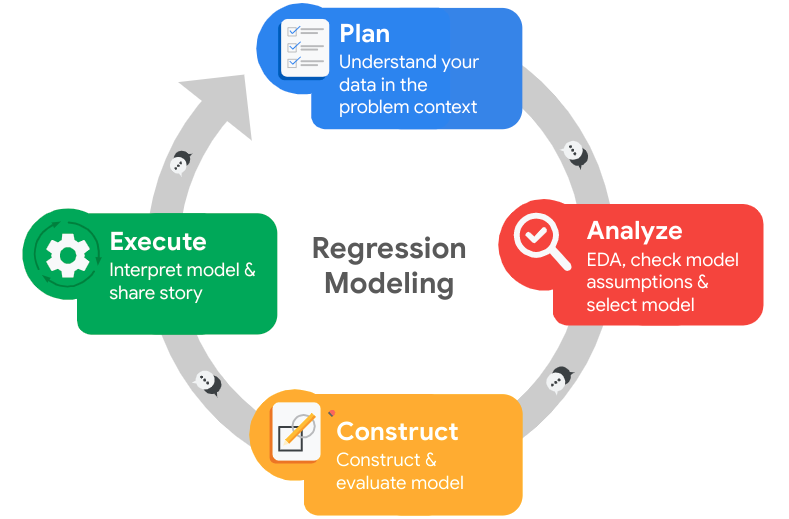

## **Pace: Plan**


### Understand the business scenario and problem

Waze’s free navigation app makes it easier for drivers around the world to get to where they want to go. Waze’s community of map editors, beta testers, translators, partners, and users helps make each drive better and safer. Waze partners with cities, transportation authorities, broadcasters, businesses, and first responders to help as many people as possible travel more efficiently and safely. 

The goals in this project are to analyze the data collected by Waze  to help prevent user churn on the Waze app.

### Questions to reflect on in the plan stage:

*  Who are the stakeholders for this project? 
- What are they trying to solve or accomplish?
- What are the initial observations when you explore the data?
- Any ethical considerations in this stage? 


In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [3]:
# Load the dataset into a dataframe
df = pd.read_csv('waze_dataset.csv')

df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone


##  Data Exploration (Initial EDA and data cleaning)

- Understand the variables
- Clean the dataset (missing data, redundant data, outliers) 


In [4]:
df.size

194987

In [5]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [7]:
# Check for missing values

df.isna().sum()

ID                           0
label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64

In [8]:
# Check for duplicates

df.duplicated().sum()

0

# pAce: Analyze Stage
- Perform EDA (analyze relationships between variables) 

### Questions  to reflect on at the analyze stage.

- What is the observation about the relationships between variables?
- What is the observation about the distributions in the data? 
- What transformations should be made with the data? Why those decisions?
- Is there any ethical considerations in this stage?


## Data Exploration (Continue EDA)

#### **`sessions`**

_The number of occurrences of a user opening the app during the month_

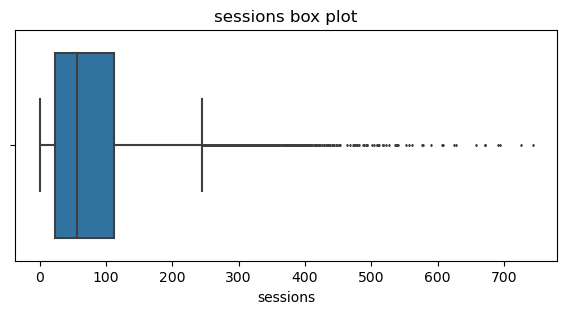

In [9]:
# Box plot
plt.figure(figsize=(7,3))
sns.boxplot(x=df['sessions'], fliersize=1)
plt.title('sessions box plot');

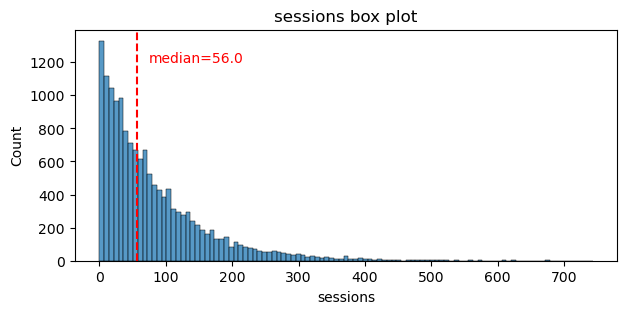

In [10]:
# Histogram
plt.figure(figsize=(7,3))
sns.histplot(x=df['sessions'])
median = df['sessions'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(75,1200, 'median=56.0', color='red')
plt.title('sessions box plot');

The `sessions` variable is a right-skewed distribution with half of the observations having 56 or fewer sessions. However, as indicated by the boxplot, some users have more than 700.

#### **`drives`**

_An occurrence of driving at least 1 km during the month_

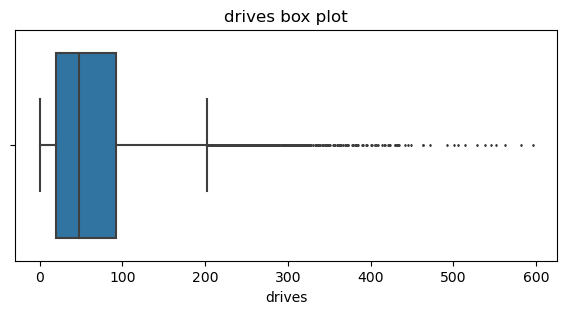

In [11]:
# Box plot
plt.figure(figsize=(7,3))
sns.boxplot(x=df['drives'], fliersize=1)
plt.title('drives box plot');

In [12]:
# Helper function to plot histograms based on the
# format of the `sessions` histogram
def histogrammer(column_str, median_text=True, **kwargs):    # **kwargs = any keyword arguments
                                                             # from the sns.histplot() function
    median=round(df[column_str].median(), 1)
    plt.figure(figsize=(7,3))
    ax = sns.histplot(x=df[column_str], **kwargs)            # Plot the histogram
    plt.axvline(median, color='red', linestyle='--')         # Plot the median line
    if median_text==True:                                    # Add median text unless set to False
        ax.text(0.25, 0.85, f'median={median}', color='red',
            ha='left', va='top', transform=ax.transAxes)
    else:
        print('Median:', median)
    plt.title(f'{column_str} histogram');

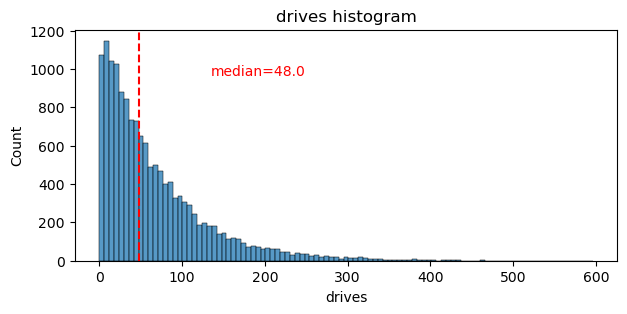

In [13]:
# Histogram
histogrammer('drives')

The `drives` information follows a distribution similar to the `sessions` variable. It is right-skewed, approximately log-normal, with a median of 48. However, some drivers had over 400 drives in the last month.

In [14]:
def boxplot(column_str):
    plt.figure(figsize=(7,3))
    ax = sns.boxplot(x=df[column_str], fliersize=2) 
    ax.set_title(f'{column_str} boxplot')

#### **`total_sessions`**

_A model estimate of the total number of sessions since a user has onboarded_

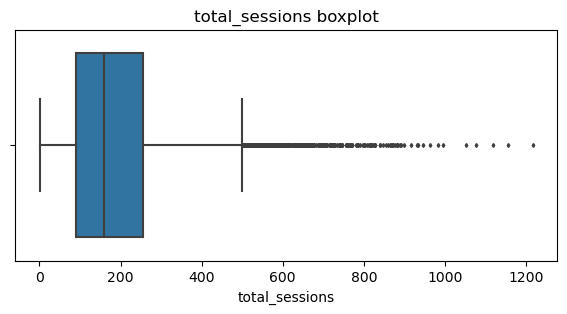

In [15]:
boxplot('total_sessions')

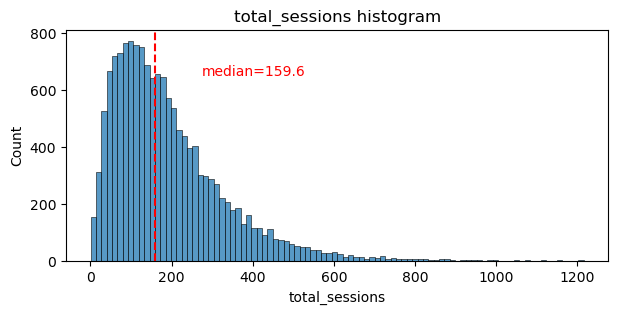

In [16]:
histogrammer('total_sessions')# Histogramhistogrammer

The `total_sessions` is a right-skewed distribution. The median total number of sessions is 159.6. This is interesting information because, if the median number of sessions in the last month was 56 and the median total sessions was ~160, then it seems that a large proportion of a user's (estimated) total drives might have taken place in the last month. 

#### **`n_days_after_onboarding`**

_The number of days since a user signed up for the app_

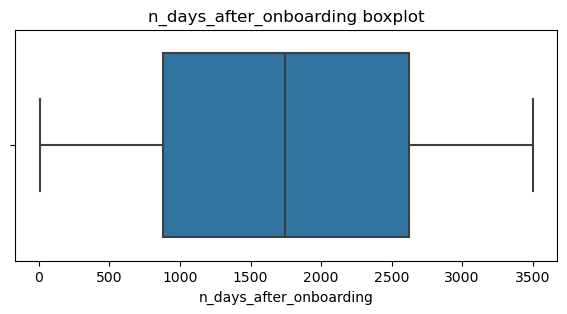

In [17]:
boxplot('n_days_after_onboarding')

Median: 1741.0


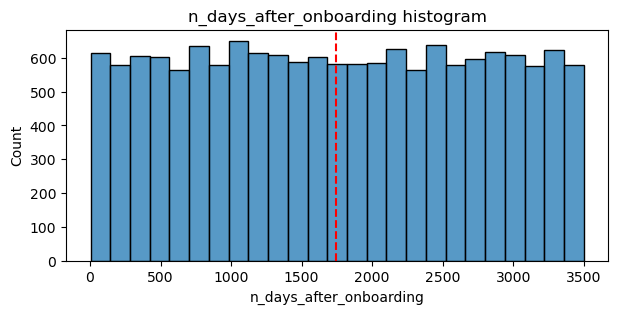

In [18]:
# Histogram
histogrammer('n_days_after_onboarding', median_text=False)

The total user tenure (i.e., number of days since
onboarding) is a uniform distribution with values ranging from near-zero to \~3,500 (\~9.5 years).

#### **`driven_km_drives`**

_Total kilometers driven during the month_

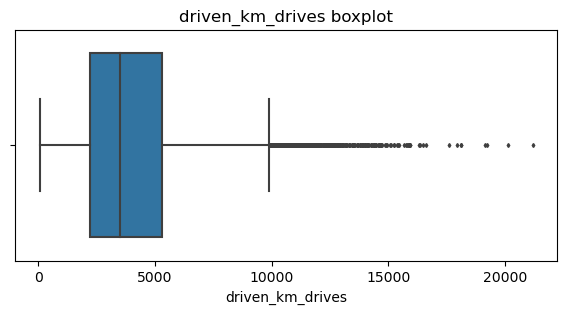

In [19]:
boxplot('driven_km_drives')

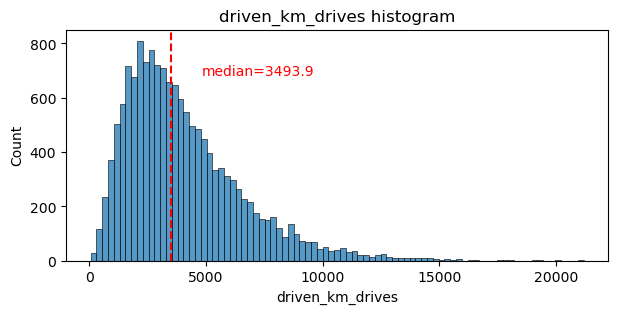

In [20]:
# Histogram
histogrammer('driven_km_drives')

The number of drives driven in the last month per user is a right-skewed distribution with half the users driving under 3,495 kilometers

#### **`duration_minutes_drives`**

_Total duration driven in minutes during the month_

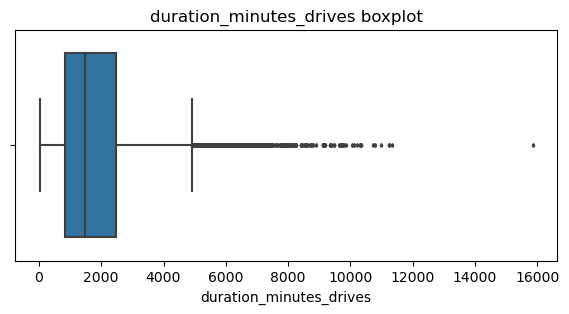

In [21]:
boxplot('duration_minutes_drives')

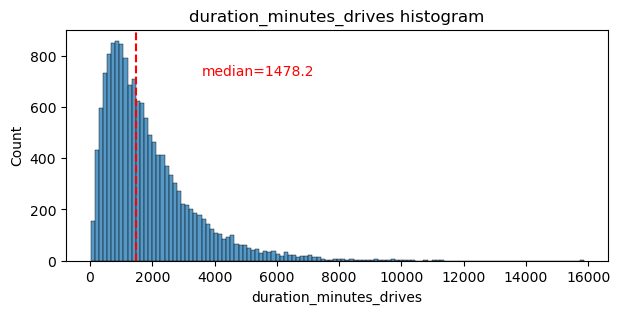

In [22]:
# Histogram
histogrammer('duration_minutes_drives')

The `duration_minutes_drives` variable has a heavily skewed right tail. Half of the users drove less than \~1,478 minutes (\~25 hours), but some users clocked over 250 hours over the month.

#### **`activity_days`**

_Number of days the user opens the app during the month_

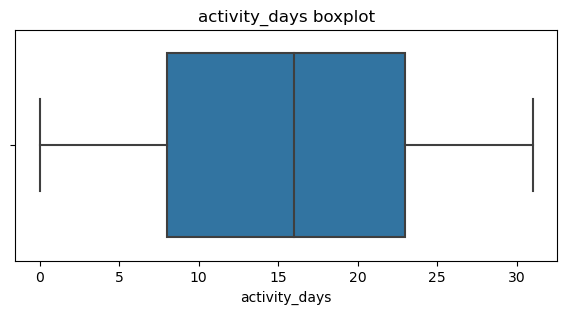

In [23]:
boxplot('activity_days')

Median: 16.0


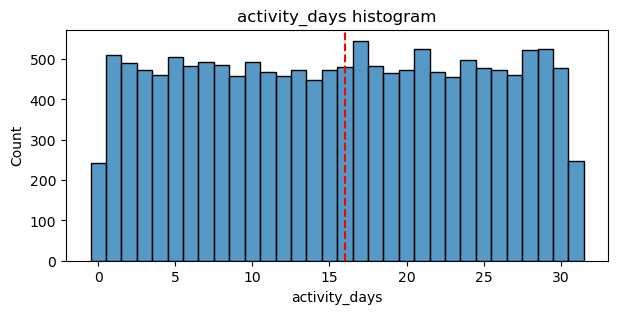

In [24]:
histogrammer('activity_days', median_text=False, discrete=True)

Within the last month, users opened the app a median of 16 times. The box plot reveals a centered distribution. The histogram shows a nearly uniform distribution of ~500 people opening the app on each count of days. However, there are ~250 people who didn't open the app at all and ~250 people who opened the app every day of the month.

This distribution is noteworthy because it does not mirror the `sessions` distribution, which you might think would be closely correlated with `activity_days`.

#### **`driving_days`**

_Number of days the user drives (at least 1 km) during the month_

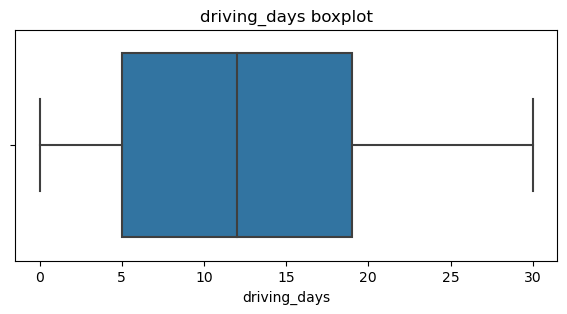

In [25]:
boxplot('driving_days')

Median: 12.0


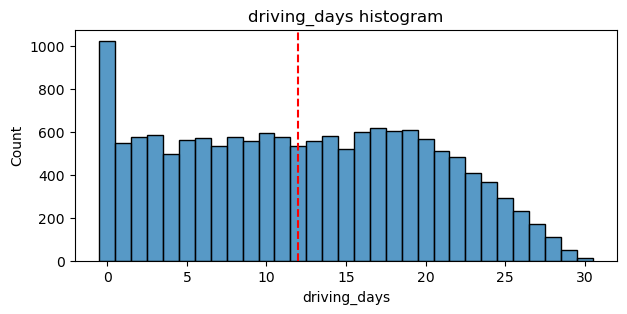

In [26]:
histogrammer('driving_days', median_text=False, discrete=True)

The number of days users drove each month is almost uniform, and it largely correlates with the number of days they opened the app that month, except the `driving_days` distribution tails off on the right.

However, there were almost twice as many users (\~1,000 vs. \~550) who did not drive at all during the month. This might seem counterintuitive when considered together with the information from `activity_days`. That variable had \~500 users opening the app on each of most of the day counts, but there were only \~250 users who did not open the app at all during the month and ~250 users who opened the app every day. Flag this for further investigation later.


#### **`device`**

_The type of device a user starts a session with_

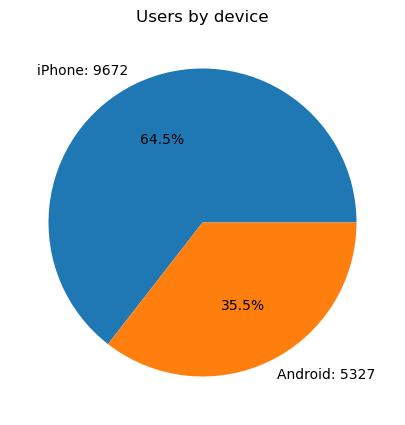

In [27]:
# Pie chart
fig = plt.figure(figsize=(7,5))
data=df['device'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Users by device');

#### **`label`**

_Binary target variable (“retained” vs “churned”) for if a user has churned anytime during the course of the month_


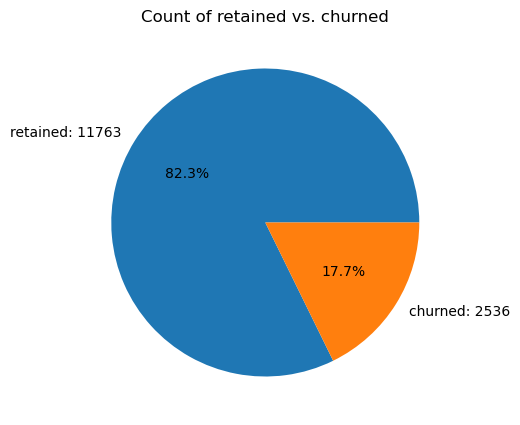

In [28]:
# Pie chart
fig = plt.figure(figsize=(7,5))
data=df['label'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Count of retained vs. churned');

#### **`driving_days` vs. `activity_days`**

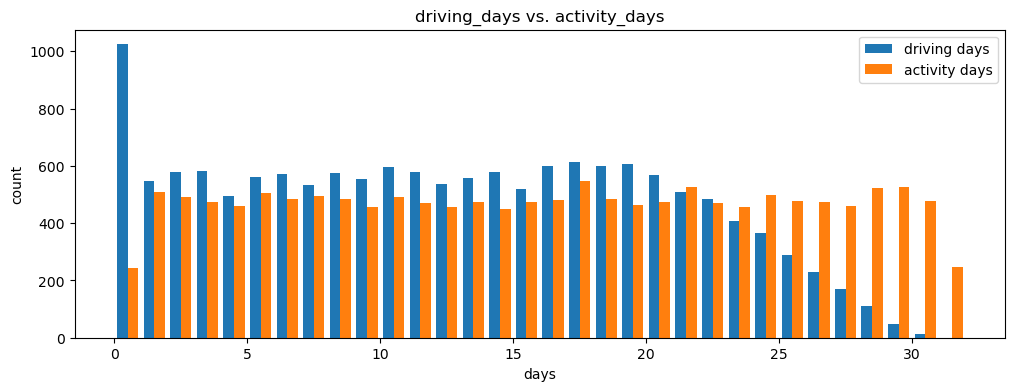

In [29]:
# Histogram
plt.figure(figsize=(12,4))
label=['driving days', 'activity days']
plt.hist([df['driving_days'], df['activity_days']],
         bins=range(0,33),
         label=label)
plt.xlabel('days')
plt.ylabel('count')
plt.legend()
plt.title('driving_days vs. activity_days');

As observed previously, this might seem counterintuitive. After all, why are there _fewer_ people who didn't use the app at all during the month and _more_ people who didn't drive at all during the month?

On the other hand, it could just be illustrative of the fact that, while these variables are related to each other, they're not the same. People probably just open the app more than they use the app to drive&mdash;perhaps to check drive times or route information, to update settings, or even just by mistake.

Nonetheless, it might be worthwile to contact the data team at Waze to get more information about this, especially because it seems that the number of days in the month is not the same between variables.

Confirm the maximum number of days for each variable&mdash;`driving_days` and `activity_days`.

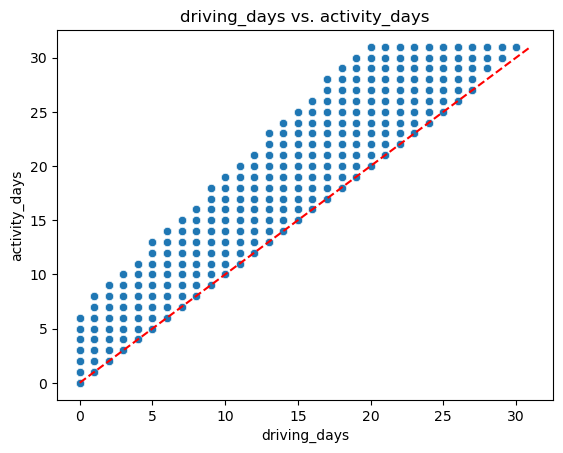

In [30]:
# Scatter plot
sns.scatterplot(data=df, x='driving_days', y='activity_days')
plt.title('driving_days vs. activity_days')
plt.plot([0,31], [0,31], color='red', linestyle='--');

Notice that there is a theoretical limit. If you use the app to drive, then by definition it must count as a day-use as well. In other words, you cannot have more drive-days than activity-days. None of the samples in this data violate this rule, which is good.

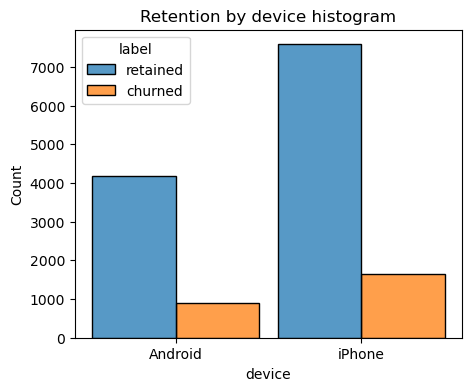

In [31]:
# Retention by device
# Histogram
plt.figure(figsize=(5,4))
sns.histplot(data=df,
             x='device',
             hue='label',
             multiple='dodge',
             shrink=0.9
             )
plt.title('Retention by device histogram');

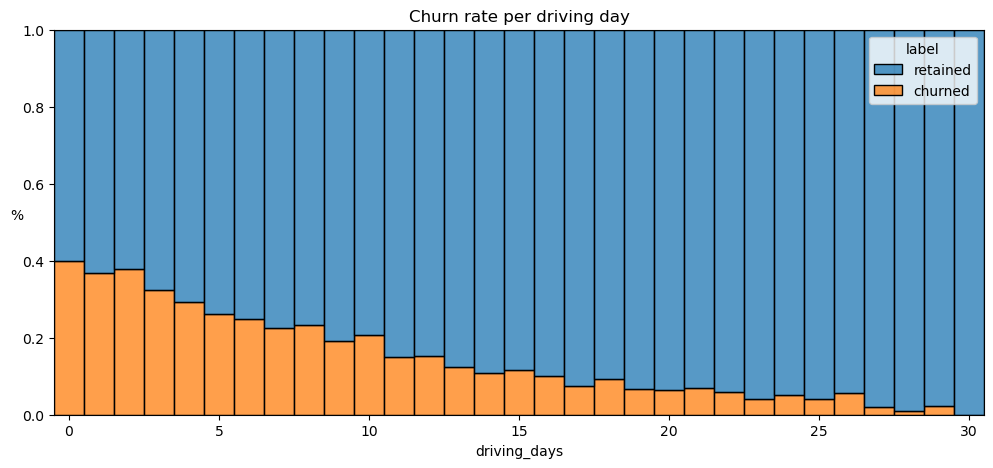

In [32]:
# Churn rate per number of driving days
# Histogram
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='driving_days',
             bins=range(1,32),
             hue='label',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.title('Churn rate per driving day');

The churn rate is highest for people who didn't use Waze much during the last month. The more times they used the app, the less likely they were to churn. While 40% of the users who didn't use the app at all last month churned, nobody who used the app 30 days churned.

This isn't surprising. If people who used the app a lot churned, it would likely indicate dissatisfaction. When people who don't use the app churn, it might be the result of dissatisfaction in the past, or it might be indicative of a lesser need for a navigational app. Maybe they moved to a city with good public transportation and don't need to drive anymore.

In [33]:
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

In [34]:
df['percent_sessions_in_last_month'].median()

0.42309702992763176

Median: 0.4


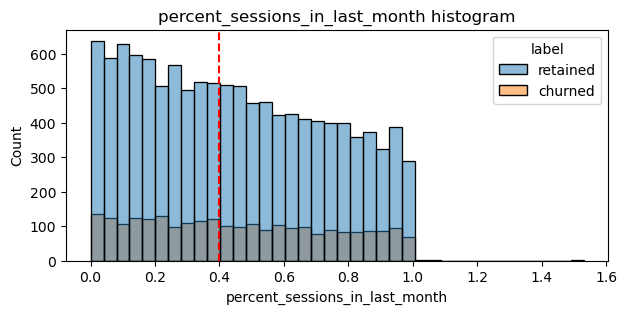

In [35]:
histogrammer('percent_sessions_in_last_month',
             hue=df['label'],
             multiple='layer',
             median_text=False)

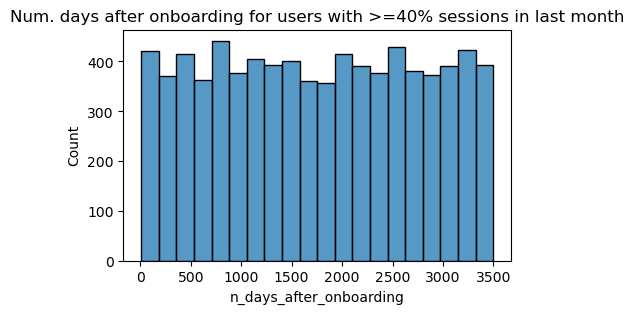

In [36]:
# Histogram
data = df.loc[df['percent_sessions_in_last_month']>=0.4]
plt.figure(figsize=(5,3))
sns.histplot(x=data['n_days_after_onboarding'])
plt.title('Num. days after onboarding for users with >=40% sessions in last month');

The number of days since onboarding for users with 40% or more of their total sessions occurring in just the last month is a uniform distribution. This is very strange. It's worth asking Waze why so many long-time users suddenly used the app so much in the last month.

### Feature engineering

In [37]:
# 1. `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2.descriptive stats
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Notice that some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.


In [38]:
# 1. Converting infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirming that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`professional_driver`**

Creating a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

In [39]:
# Creating `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

#### **`total_sessions_per_day`**

The mean number of sessions per day _since onboarding_.

In [40]:
# CreatING `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

#### **`km_per_hour`**
The mean kilometers per hour driven in the last month.

In [41]:
# Creating `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

These numbers are obviously problematic, and it would be worthwhile to seek clarification from Waze regarding how these features are collected to better understand why such unrealistic speeds are observed.

#### **`km_per_drive`**

The mean number of kilometers per drive made in the last month for each user

In [42]:
# Creating `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [43]:
# 1. Converting infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# 2. Confirming that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

The percentage of total sessions that were used to navigate to one of the users' favorite places

In [44]:
# Creating `percent_of_sessions_to_favorite` feature
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Geting descriptive stats
df['percent_of_drives_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

In [45]:
# Droping rows with missing values
df = df.dropna(subset=['label'])

### **Outliers**

Many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need making any imputations.

### **Variable encoding**

#### **Dummying features**

In order to use `device` as an X variable, it will need to be converted to binary, since this variable is categorical.


In [46]:
# Creating new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


#### **Target encoding**

The target variable is also categorical, since a user is labeled as either "churned" or "retained." Changing the data type of the `label` column to be binary. This change is needed to train the models

In [47]:
# Creating binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### **Feature selection**

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

In [48]:
# Droping `ID` column
df = df.drop(['ID'], axis=1)

In [49]:
# Geting class balance of 'label' col
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

# paCe: Construct Stage
- Determine which models are most appropriate
- Construct the model 
- Confirm model assumptions
- Evaluate model results to determine how well your model fits the data


### Questions to reflect on at this stage.

- Anything odd?
- Which independent variables were choseh for the model and why?
- Are each of the assumptions met?
- How well does the model fit the data?
- Can it be improved? Is there anything that can change about the model?
- Any ethical considerations in this stage?


In [50]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

In [51]:
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


### **Modeling**

In [52]:
# 1. Instantiating the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [53]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 3min 16s
Wall time: 3min 17s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'recall', 'precision', 'accuracy', 'f1'})

In [54]:
# Examining best score
rf_cv.best_score_

0.12677683381682553

In [55]:
# Examining best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [56]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [57]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.459318,0.126777,0.198539,0.818976


#### **XGBoost**

 Trying to improve your scores using an XGBoost model.


In [58]:
# 1. Instantiating the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Defining a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiating the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [59]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 2min 56s
Wall time: 57.1 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'recall', 'precision', 'accuracy', 'f1'})

In [60]:
# Examining best score
xgb_cv.best_score_

0.1708264263019754

In [61]:
# Examining best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

In [62]:
# Calling 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.459318,0.126777,0.198539,0.818976
0,XGB cv,0.425932,0.170826,0.243736,0.811866


This model fit the data even better than the random forest model. The recall score is 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### **Model selection**

Now, I will use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Random forest**

In [63]:
# Using random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [64]:
# Using the 'get_test_scores()' function to generate a table of scores from the predictions on the validation data.

def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [65]:
# Geting validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.459318,0.126777,0.198539,0.818976
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.442177,0.128205,0.198777,0.816783


The scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**

In [66]:
# Using XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Geting validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Appending to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.459318,0.126777,0.198539,0.818976
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.442177,0.128205,0.198777,0.816783
0,XGB val,0.422680,0.161736,0.233951,0.812238


# pacE: Execute Stage
- Interpret model performance and results
- Share actionable steps with stakeholders


### **Using champion model to predict on test data**

In [67]:
# Using XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Geting test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Appending to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.459318,0.126777,0.198539,0.818976
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.442177,0.128205,0.198777,0.816783
0,XGB val,0.422680,0.161736,0.233951,0.812238
0,XGB test,0.423963,0.181460,0.254144,0.811189


The recall was exactly the same as it was on the validation data, but the precision declined notably, which caused all of the other scores to drop slightly. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores.

### **Confusion matrix**

Ploting a confusion matrix of the champion model's predictions on the test data.

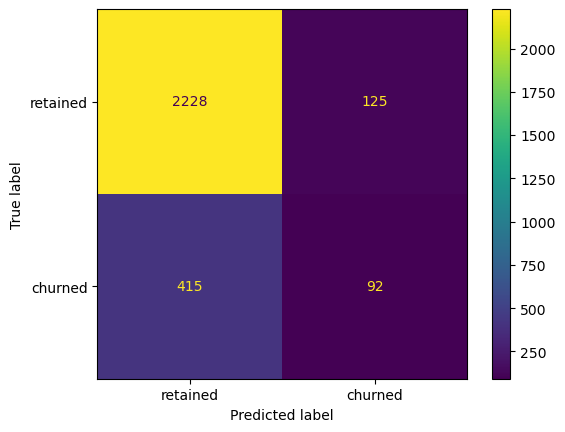

In [68]:
# Generating array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Ploting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

### **Feature importance**

Using the `plot_importance` function to inspect the most important features of your final model.

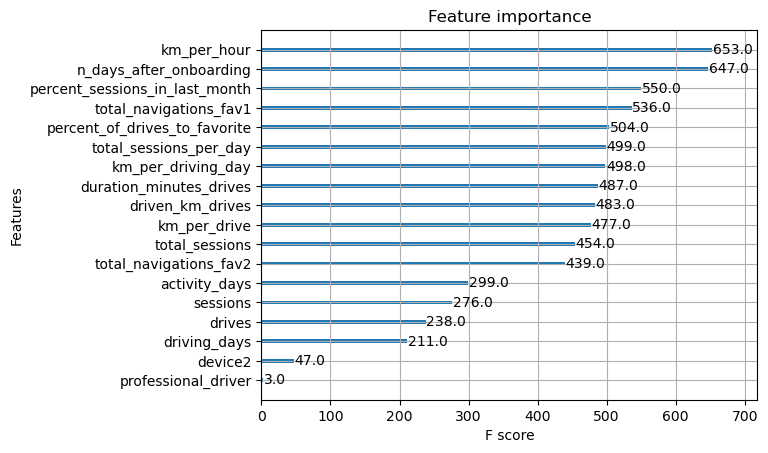

In [69]:
plot_importance(xgb_cv.best_estimator_);

The XGBoost model made more use of many of the features.
If anything, this underscores the importance of feature engineering. Notice that engineered features accounted for six of the top 10 features (and three of the top five)

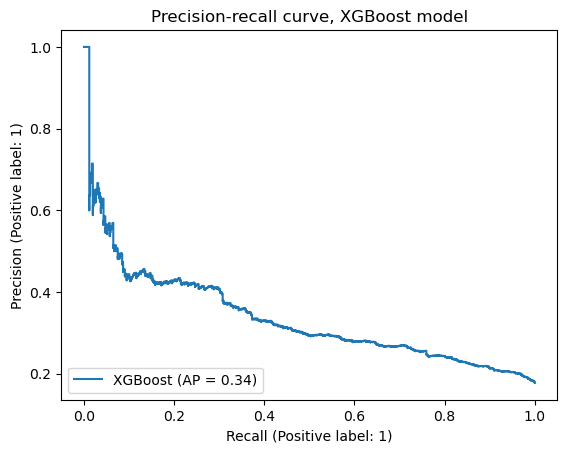

In [70]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

As recall increases, precision decreases. But what if it is determined that false positives aren't much of a problem? For example, in the case of this Waze project, a false positive could just mean that a user who will not actually churn gets an email and a banner notification on their phone. It's very low risk.